# Linear Regression

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sb
from statsconcepts.viz import Viz

%load_ext autoreload
%aimport statsconcepts.viz
%autoreload 1

## Input Data

For this exposition, we will leverage the "tips" dataset provided by the `seaborn` package.

In [2]:
df: pd.DataFrame = sb.load_dataset("tips")
df.index.name = "transaction"
data: xr.Dataset = xr.Dataset(df)
    
data

<xarray.Dataset>
Dimensions:      (transaction: 244)
Coordinates:
  * transaction  (transaction) int64 0 1 2 3 4 5 6 ... 238 239 240 241 242 243
Data variables:
    total_bill   (transaction) float64 16.99 10.34 21.01 ... 22.67 17.82 18.78
    tip          (transaction) float64 1.01 1.66 3.5 3.31 ... 2.0 2.0 1.75 3.0
    sex          (transaction) object 'Female' 'Male' 'Male' ... 'Male' 'Female'
    smoker       (transaction) object 'No' 'No' 'No' 'No' ... 'Yes' 'No' 'No'
    day          (transaction) object 'Sun' 'Sun' 'Sun' ... 'Sat' 'Sat' 'Thur'
    time         (transaction) object 'Dinner' 'Dinner' ... 'Dinner' 'Dinner'
    size         (transaction) int64 2 3 3 2 4 4 2 4 2 2 ... 2 2 2 2 3 3 2 2 2 2

## What is the distribution of tips? 

<AxesSubplot:xlabel='tip', ylabel='Count'>

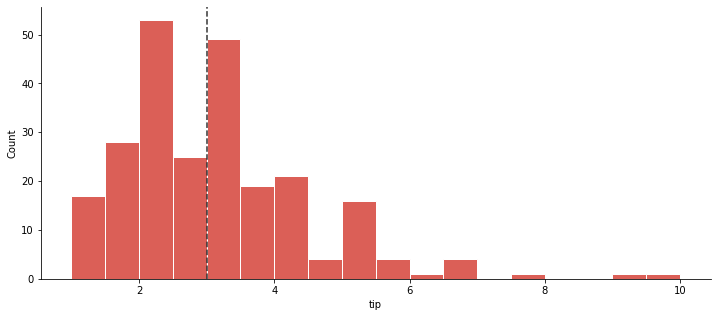

In [95]:
overall_d: Viz = Viz(data)
overall_d.univariate_hist("tip")

<AxesSubplot:title={'center':'Distribution of Total Bill (Avg = 19.79)'}, xlabel='total_bill', ylabel='Count'>

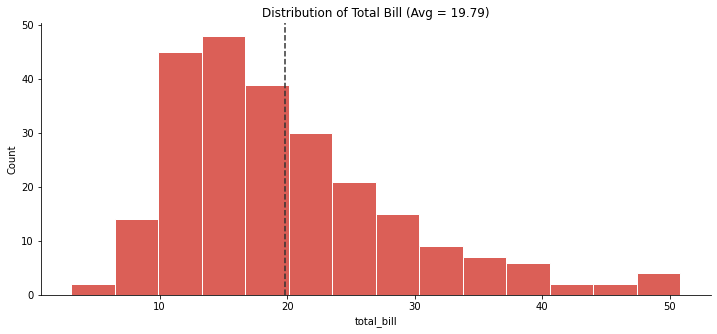

In [103]:
overall_d.univariate_hist("total_bill", title="Distribution of Total Bill")

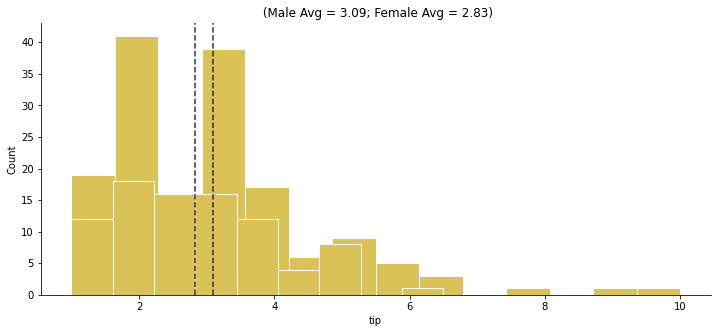

In [120]:
compare = overall_d.univariate_compare(
    "tip",
    data.where(data.sex == "Male", drop=True),
    data.where(data.sex == "Female", drop=True),
    "Male",
    "Female",
    facecolor=overall_d.colors[1]
)

In [130]:
np.mean.__name__

'mean'

In [107]:
data

<xarray.Dataset>
Dimensions:      (transaction: 244)
Coordinates:
  * transaction  (transaction) int64 0 1 2 3 4 5 6 ... 238 239 240 241 242 243
Data variables:
    total_bill   (transaction) float64 16.99 10.34 21.01 ... 22.67 17.82 18.78
    tip          (transaction) float64 1.01 1.66 3.5 3.31 ... 2.0 2.0 1.75 3.0
    sex          (transaction) object 'Female' 'Male' 'Male' ... 'Male' 'Female'
    smoker       (transaction) object 'No' 'No' 'No' 'No' ... 'Yes' 'No' 'No'
    day          (transaction) object 'Sun' 'Sun' 'Sun' ... 'Sat' 'Sat' 'Thur'
    time         (transaction) object 'Dinner' 'Dinner' ... 'Dinner' 'Dinner'
    size         (transaction) int64 2 3 3 2 4 4 2 4 2 2 ... 2 2 2 2 3 3 2 2 2 2

In [64]:
from typing import List, TypeVar

A = TypeVar("A")

[]

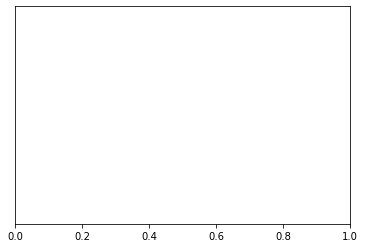

In [81]:
fig, ax = plt.subplots()
ax.set_yticks([])

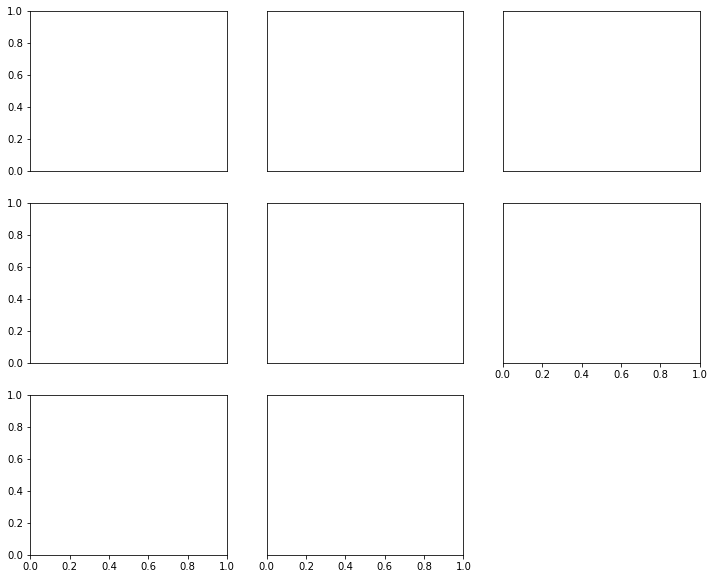

In [93]:
grps: List[str] = ["a", "b", "c", "d", "e", "f", "g", "h"]
Viz.group_axes(grps, n_cols=3, figsize=(12, 10), sharey=True, sharex=True)